In [1]:
import os
os.chdir('./4-4/neural_style_transfer/')
import nst_utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from imageio import imread
from PIL import Image

In [2]:
tf.reset_default_graph()
model = nst_utils.load_vgg_model('pretrained-model/imagenet-vgg-verydeep-19.mat')
print(type(model))
for key,value in model.items():
    print(key, '\t', value, end='\n\n')


<class 'dict'>
input 	 <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>

conv1_1 	 Tensor("Relu:0", shape=(1, 300, 400, 64), dtype=float32)

conv1_2 	 Tensor("Relu_1:0", shape=(1, 300, 400, 64), dtype=float32)

avgpool1 	 Tensor("AvgPool:0", shape=(1, 150, 200, 64), dtype=float32)

conv2_1 	 Tensor("Relu_2:0", shape=(1, 150, 200, 128), dtype=float32)

conv2_2 	 Tensor("Relu_3:0", shape=(1, 150, 200, 128), dtype=float32)

avgpool2 	 Tensor("AvgPool_1:0", shape=(1, 75, 100, 128), dtype=float32)

conv3_1 	 Tensor("Relu_4:0", shape=(1, 75, 100, 256), dtype=float32)

conv3_2 	 Tensor("Relu_5:0", shape=(1, 75, 100, 256), dtype=float32)

conv3_3 	 Tensor("Relu_6:0", shape=(1, 75, 100, 256), dtype=float32)

conv3_4 	 Tensor("Relu_7:0", shape=(1, 75, 100, 256), dtype=float32)

avgpool3 	 Tensor("AvgPool_2:0", shape=(1, 38, 50, 256), dtype=float32)

conv4_1 	 Tensor("Relu_8:0", shape=(1, 38, 50, 512), dtype=float32)

conv4_2 	 Tensor("Relu_9:0", shape=(1, 38, 50, 512), dtype=

## what to do
- Build J_content(C, G)
- Build J_style(S, G)
- Build J(G) = alpha * J_content(C, G) + beta * J_style(S, G)

(300, 400, 3)


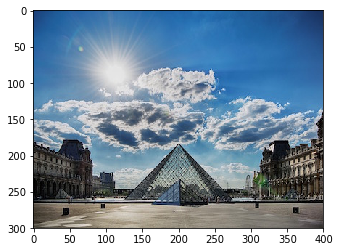

In [3]:
C = imread('./images/louvre_small.jpg')
print(C.shape)
plt.imshow(C)

In [4]:
def compute_J_content(a_C, a_G):

    '''
    input:
        a_C - (1, n_H, n_W, n_C), Tensor, activation of content image
        a_G - (1, n_H, n_W, n_C), Tensor, actication of generate image
    output:
        J_content = 1/(2*n_H*n_W*n_C) * ||a_C - a_G||**2
    '''

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    J_content = (1/(4*n_H*n_W*n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))
    return J_content

(300, 400, 3)


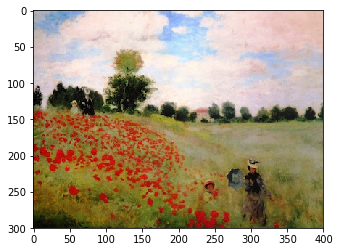

In [5]:
S = imread('./images/monet.jpg')
print(S.shape)
plt.imshow(S)

In [6]:
def compute_J_style(gram_S_list, gram_G_list, lambd_list=[0.2, 0.2, 0.2, 0.2, 0.2]):

    '''
    use layers[conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]

    input:
        gram_S_list - (n_C, n_C), list of Tensor, gram matrix of style image in layers
        gram_G_list - (n_C, n_C), list of Tensor, gram matrix of generate image in layers
        lambd_lsit - weight of J in different layers
    output:
        J_style = sum(lambd * J_style_layer)
    '''

    J_style = 0.
    for i in range(5):
        gram_S = gram_S_list[i]
        gram_G = gram_G_list[i]
        n_C, n_C = gram_G.get_shape().as_list()
        lambd = lambd_list[i]
        J_style_layer = (1/(4 * n_C**2)) * tf.reduce_sum(tf.square(tf.subtract(gram_S, gram_G)))
        J_style += lambd * J_style_layer
        
    return J_style

In [7]:
def gram(a):
    
    '''
    input:
        a - activation of a layer, Tensor, (1, n_H, n_W, n_C)
    output:
        gram_matrix - (n_C, n_C)
    '''

    m, n_H, n_W, n_C = a.get_shape().as_list()
    a_2D = tf.reshape(a, [-1, n_C])
    a_2D_T = tf.transpose(a_2D)
    gram_matrix = tf.matmul(a_2D_T, a_2D) / (n_H * n_W)
    return gram_matrix

In [8]:
def gram_list(a_list):
    '''
    a_list - from layers[conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]
    '''
    gram_matrix_list = [gram(a) for a in a_list]
    return gram_matrix_list

In [9]:
def compute_J(a_C, a_G, a_S_list, a_G_list, alpha=10, beta=40):
    J_content = compute_J_content(a_C, a_G)
    J_style = compute_J_style(gram_list(a_S_list), gram_list(a_G_list), lambd_list=[0.2, 0.2, 0.2, 0.2, 0.2])
    J = alpha * J_content + beta * J_style
    return J

In [10]:
### 

<class 'numpy.ndarray'> (1, 38, 50, 512)


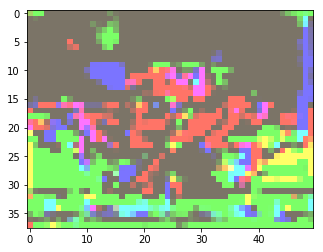

In [11]:
# 计算a_C

Content = nst_utils.reshape_and_normalize_image(C)
op1 = model['input'].assign(Content)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run(op1)
    a_C = sess.run(model["conv4_2"])
    print(type(a_C),a_C.shape)
    plt.imshow(np.squeeze(np.clip((a_C[:,:,:,0:3]+nst_utils.CONFIG.MEANS),0,255).astype('uint8')))

In [12]:
a_C = tf.constant(a_C)
print(a_C.shape, type(a_C))

(1, 38, 50, 512) <class 'tensorflow.python.framework.ops.Tensor'>


<class 'list'> 5


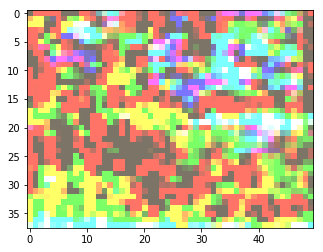

In [13]:
# 计算a_S_list

Style = nst_utils.reshape_and_normalize_image(S)
op2 = model['input'].assign(Style)
with tf.Session() as sess:
    init = model['input'].initializer
    sess.run(init)
    sess.run(op2)
    a_S_list = sess.run([model["conv1_1"], model["conv2_1"], model["conv3_1"], model["conv4_1"], model['conv5_1']])
    print(type(a_S_list),len(a_S_list))
    plt.imshow(np.squeeze(np.clip((a_S_list[3][:,:,:,0:3]+nst_utils.CONFIG.MEANS),0,255).astype('uint8')))

In [14]:
a_S_list = [tf.constant(x) for x in a_S_list]
print(a_S_list[0])

Tensor("Const_33:0", shape=(1, 300, 400, 64), dtype=float32)


## Build compute graph

In [15]:
input_image = nst_utils.generate_noise_image(Content, noise_ratio=nst_utils.CONFIG.NOISE_RATIO)
G = model['input']
op3 = G.assign(input_image)
a_G = model["conv4_2"]
a_G_list = [model["conv1_1"], model["conv2_1"], model["conv3_1"], model["conv4_1"], model['conv5_1']]
J = compute_J(a_C, a_G, a_S_list, a_G_list, alpha=1000, beta=4000)
optimizer = tf.train.AdamOptimizer(2).minimize(J)
init = tf.global_variables_initializer()

## Train

In [16]:
sess = tf.Session()
sess.run(init)
sess.run(op3)

array([[[[-3.0327789e+01, -2.7320047e+01,  1.4832629e+01],
         [-4.7120781e+01, -2.3443277e+01,  5.0679822e+00],
         [-3.3186821e+01, -2.8004581e+01,  5.9006343e+00],
         ...,
         [-4.9424519e+01, -3.2249027e+01,  7.1738677e+00],
         [-4.5521557e+01, -3.1867851e+01,  7.6365075e+00],
         [-4.0265739e+01, -2.1268513e+01, -1.0884420e+01]],

        [[-3.7505882e+01, -2.7010471e+01,  5.4495301e+00],
         [-4.6966576e+01, -2.0533600e+01,  1.5699231e+01],
         [-4.6190849e+01, -1.8714378e+01,  3.4531136e+00],
         ...,
         [-2.9984045e+01, -2.5304848e+01, -1.0770489e+01],
         [-3.3126354e+01, -1.8092390e+01, -8.9053411e+00],
         [-4.9411461e+01, -3.3428970e+01, -2.7334686e-02]],

        [[-4.2385860e+01, -3.1439035e+01,  7.7436123e+00],
         [-4.5587696e+01, -1.1774934e+01,  7.3123064e+00],
         [-3.4206669e+01, -1.2607773e+01, -9.5236629e-01],
         ...,
         [-4.3003063e+01, -2.5552397e+01, -7.0024447e+00],
         [

In [17]:
for epoch in range(5):
    _, loss = sess.run([optimizer, J])
    print(epoch, loss)
    image_gen = sess.run(G)
    if epoch % 1 == 0:
        nst_utils.save_image(f'./output/{epoch}.png', image_gen)

0 587435200000.0
1 586408900000.0
2 nan
3 nan
4 nan


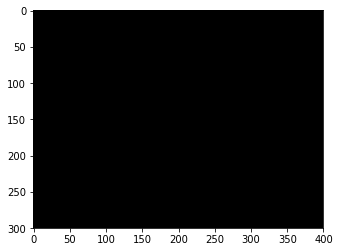

In [18]:
image_gen = image_gen + nst_utils.CONFIG.MEANS
output_image = np.clip(image_gen[0], 0, 255).astype('uint8')
plt.imshow(output_image)

In [19]:
# sess.close()